In [172]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [173]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('/content/2357.TW.csv')
df1=df.reset_index()['Close']

In [174]:
# 3. Scale data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [175]:
# 4. Chia train test
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [176]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [177]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [178]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [179]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [180]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 57ms/step - loss: 0.0165 - val_loss: 0.1578
Epoch 2/100
9/9 [==============================] - 0s 30ms/step - loss: 0.0035 - val_loss: 0.0661
Epoch 3/100
9/9 [==============================] - 0s 35ms/step - loss: 0.0021 - val_loss: 0.0485
Epoch 4/100
9/9 [==============================] - 0s 30ms/step - loss: 0.0012 - val_loss: 0.0321
Epoch 5/100
9/9 [==============================] - 0s 35ms/step - loss: 0.0010 - val_loss: 0.0239
Epoch 6/100
9/9 [==============================] - 1s 60ms/step - loss: 9.2911e-04 - val_loss: 0.0249
Epoch 7/100
9/9 [==============================] - 1s 64ms/step - loss: 8.1781e-04 - val_loss: 0.0252
Epoch 8/100
9/9 [==============================] - 0s 52ms/step - loss: 7.6116e-04 - val_loss: 0.0226
Epoch 9/100
9/9 [==============================] - 0s 56ms/step - loss: 7.5128e-04 - val_loss: 0.0226
Epoch 10/100
9/9 [==============================] - 1s 63ms/step - loss: 6.9807e-04 - val_loss: 0.0225

In [181]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 8ms/step


In [182]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [183]:
# 12. Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 268.0910352010599
Testing RMSE: 342.32585172127705
Validation MAE: 267.3318307014358
Testing MAE: 341.63094423829347
Validation MAPE: 674.6261885969277
Testing MAPE: 449.70237433762094


In [185]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=209
i=0
while(i<30):

    if(len(temp_input)>209):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.44769874 0.4623431  0.4623431  0.4665272  0.47280335 0.4623431
 0.44560669 0.4665272  0.38284519 0.34309623 0.35146444 0.36610879
 0.38493724 0.39330544 0.39539749 0.37656904 0.34937238 0.35564854
 0.36820084 0.34518828 0.36192469 0.35355649 0.34309623 0.34728033
 0.36610879 0.35355649 0.29916318 0.32845188 0.34937238 0.35983264
 0.34309623 0.34937238 0.35983264 0.35146444 0.34728033 0.32845188
 0.31799163 0.31589958 0.28451883 0.29916318 0.28033473 0.28033473
 0.26569038 0.26569038 0.29079498 0.30753138 0.30753138 0.25313808
 0.22803347 0.25523013 0.25313808 0.25313808 0.25732218 0.27615063
 0.28661088 0.25732218 0.24476987 0.25313808 0.25523013 0.27196653
 0.26150628 0.26569038 0.27405858 0.27405858 0.28033473 0.27196653
 0.26778243 0.28033473 0.29916318 0.30962343 0.29497908 0.32845188
 0.32426778 0.34100418 0.34100418 0.34937238 0.35774059 0.36610879
 0.37866109 0.39539749 0.40585774 0.39539749 0.39748954 0.40376569
 0.39958159 0.42259414 0.44560669 0.4707113  0.4476

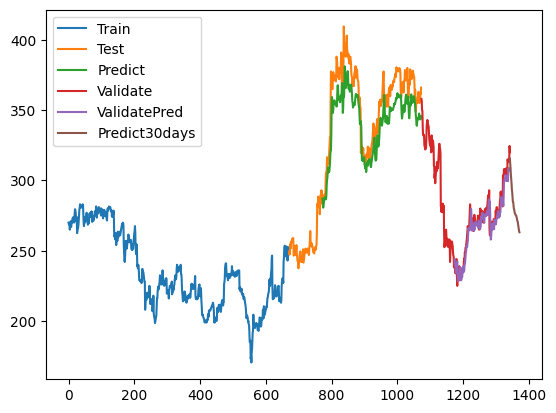

In [186]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')